In [1]:
%matplotlib inline
# uncomment the next line to enable interactive plots.
#%matplotlib qt5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3 as sql

In [2]:
# uncomment this block if you have an Intel machine.
# (It is recommended for better performance, but not mandatory.)
#from sklearnex import patch_sklearn
#patch_sklearn()

In [3]:
# Take only n elements from the database (None for no limit.)
n = None
# Random seed for all random things.
random_state = 0

In [15]:
conn = sql.connect('c3.db')
query = 'SELECT slope, offset, delta1, delta2, fano_index from periods'
if n:
    query += f' limit {n};'
df = pd.read_sql_query(query, conn)
df.describe()

slope       offset       delta1       delta2   fano_index
count  8295.000000  8295.000000  8295.000000  8295.000000  8295.000000
mean      2.949639   -14.559130    16.936347    22.731525     1.036287
std       0.652564     0.793067     5.315038     5.739430     0.437852
min       1.239824   -17.346565     1.000000     2.000000     1.000000
25%       2.466011   -15.131947    13.000000    19.000000     1.000000
50%       2.936071   -14.577793    18.000000    23.000000     1.000000
75%       3.416425   -14.001727    21.000000    27.000000     1.000000
max       5.445876   -10.592615    31.000000    35.000000    19.000000

In [54]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#sc = StandardScaler()
sc = MinMaxScaler()

df[['rslope', 'roffset']] = sc.fit_transform(df[['slope', 'offset']])
df[['rdelta1', 'rdelta2']] = sc.fit_transform(df[['delta1', 'delta2']])

Text(0, 0.5, 'Ehrhart $\\delta_1$')

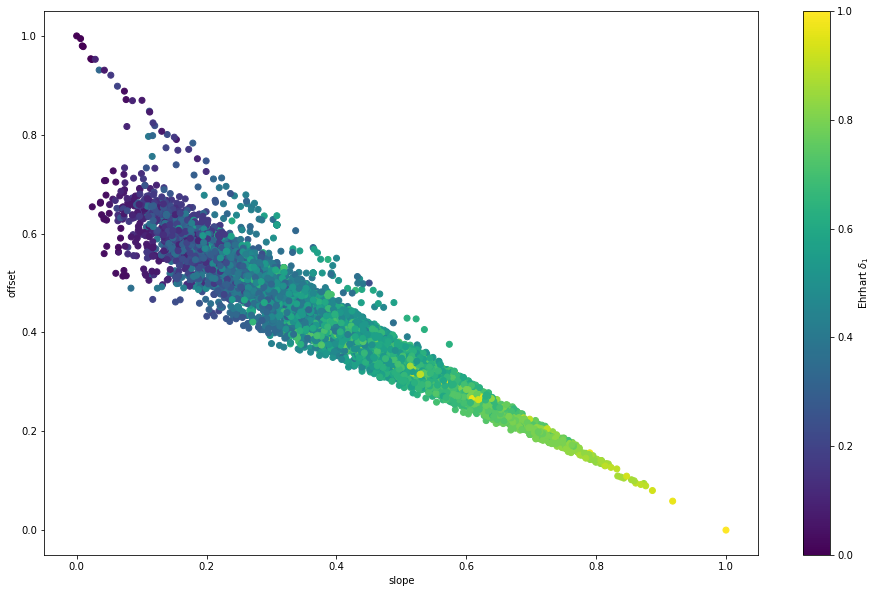

In [55]:
fig, ax = plt.subplots(figsize=(16,10))
scp = ax.scatter(df['rslope'], df['roffset'], c=df['rdelta1'])
ax.set_xlabel('slope')
ax.set_ylabel('offset')
cb = fig.colorbar(scp)
cb.ax.set_ylabel(r'Ehrhart $\delta_1$')


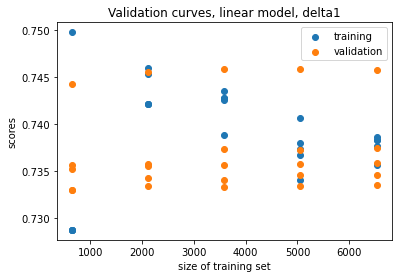

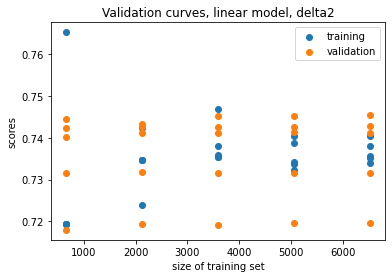

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

def plot_validation_curves(X, y, model, model_name, cv=5):
    '''
    Fits a statistical model to the data (X, y), and plots the training/
    validation curves for several sizes of the training dataset (using
    cross-validation).
    '''
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y, cv=cv,
        scoring='explained_variance')

    fig, ax = plt.subplots()
    for i, n in enumerate(train_sizes):
        if i == 0:
            labelt, labelv = 'training', 'validation'
        else:
            labelt, labelv = None, None
        ax.scatter([n for _ in train_scores[i]], train_scores[i, :], c='C0', label=labelt)
        ax.scatter([n for _ in valid_scores[i]], valid_scores[i, :], c='C1', label=labelv)
    ax.legend(loc='best')
    ax.set_xlabel('size of training set')
    ax.set_ylabel('scores')
    ax.set_title(f'Validation curves, {model_name}, delta{delta}')
    plt.show()


## Throw away the Fano indexes > 1 and NaNs.
mask = (df['fano_index'] == 1) & ~(np.any(np.isnan(df), axis=1))
indices = np.arange(df.shape[0])[mask]
rng = np.random.default_rng(random_state)
rng.shuffle(indices)
# Full data for cross-validation
coords = ['rslope', 'roffset']
X = df[coords].iloc[indices]
y = [df['rdelta1'].iloc[indices],
     df['rdelta2'].iloc[indices]]
    
    
for delta in (1, 2):
    # Target
    plot_validation_curves(X, y[delta - 1], LinearRegression(), 'linear model')


Text(0, 0.5, 'Ehrhart $\\delta_1$')

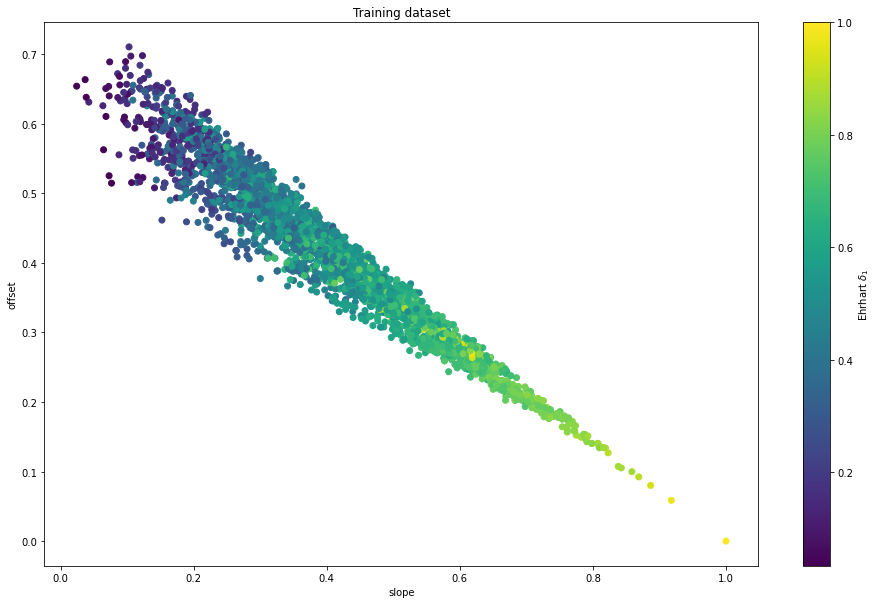

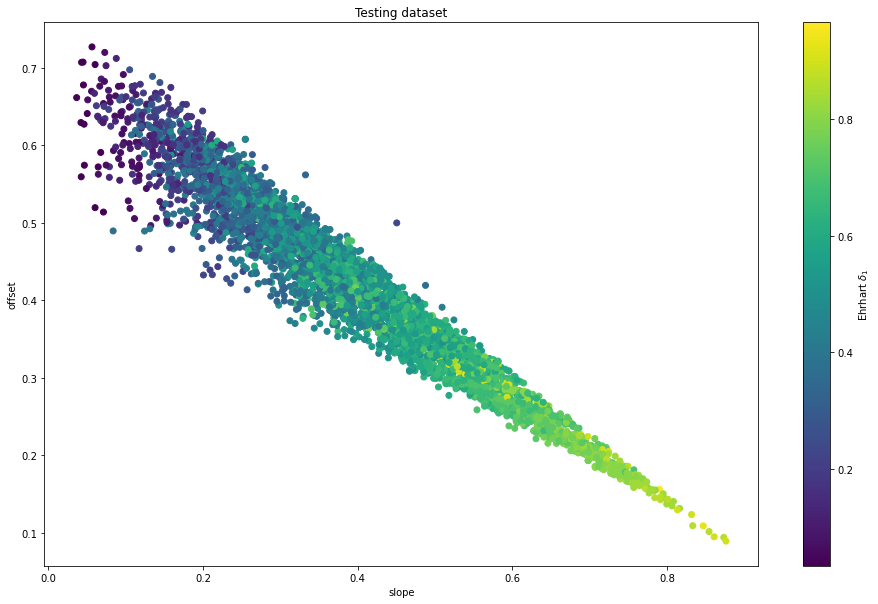

In [66]:
# Size of the training set
n_train = 3_000


# Training set
X_train = df[coords].iloc[indices[:n_train]]
y_train = [df['rdelta1'].iloc[indices[:n_train]],
           df['rdelta2'].iloc[indices[:n_train]]]
# Test set
X_test = df[coords].iloc[indices[n_train:]]
y_test = [df['rdelta1'].iloc[indices[n_train:]],
          df['rdelta2'].iloc[indices[n_train:]]]

## Scatter plot of the training and testing sets.
fig, ax = plt.subplots(figsize=(16,10))
scp = ax.scatter(X_train['rslope'], X_train['roffset'], c=y_train[0])
ax.set_xlabel('slope')
ax.set_ylabel('offset')
ax.set_title('Training dataset')
cb = fig.colorbar(scp)
cb.ax.set_ylabel(r'Ehrhart $\delta_1$')

fig, ax = plt.subplots(figsize=(16,10))
scp = ax.scatter(X_test['rslope'], X_test['roffset'], c=y_test[0])
ax.set_xlabel('slope')
ax.set_ylabel('offset')
ax.set_title('Testing dataset')
cb = fig.colorbar(scp)
cb.ax.set_ylabel(r'Ehrhart $\delta_1$')

KeyError: 'slope'

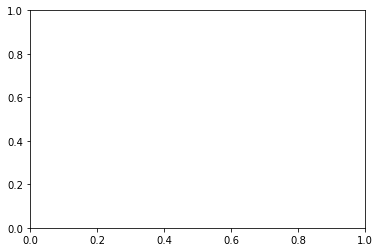

In [58]:
# column data used for coloring the scatter plot.
col_color = 'rdelta1'
# if True, plots the prediction error, otherwise makes a
# side-by-side plot of the data and the predictions.
plot_error = True

lin_model = LinearRegression()
lin_model.fit(X_train, y_train[0])
predictions = [lin_model.predict(X_test)]

lin_model.fit(X_train, y_train[1])
predictions.append(lin_model.predict(X_test))


def compare_scatter(X, data, pred, title, plot_error=False):
    '''
    Compares data with pred as a scatter plot.
    If plot_error is False, plot data and pred side by side.
    Otherwise, plots the l2 norm of the difference between
    data and pred.
    '''
    if plot_error:
        fig, ax = plt.subplots()
        c = np.sqrt(np.square(data - pred))
        s = ax.scatter(X['slope'], X['offset'], c=c)
        ax.set_xlabel('slope')
        ax.set_ylabel('offset')
        ax.set_title(title)
        fig.colorbar(s)
    else:
        fig, ax = plt.subplots(1, 2)
        # data
        ax[0].scatter(X['slope'], X['offset'], c=data)
        ax[0].set_xlabel('slope')
        ax[0].set_ylabel('offset')
        ax[0].set_title('data')
        # linear predictor
        ax[1].scatter(X['slope'], X['offset'], c=pred)
        ax[1].set_xlabel('slope')
        ax[1].set_title('prediction')
    plt.show()


compare_scatter(X_test,
                y_test[0],
                predictions[0],
                r'Error on $\delta_1$',
                plot_error=plot_error)

print("Prediction accuracy on delta2.")

compare_scatter(X_test,
                y_test[1],
                predictions[1],
                r'Error on $\delta_2$',
                plot_error=plot_error)

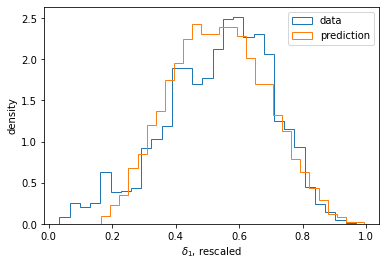

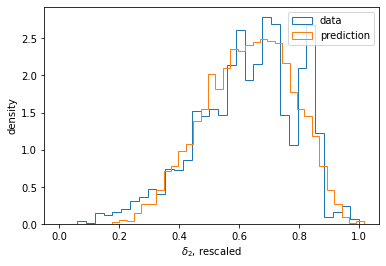

Density plots in log scale:


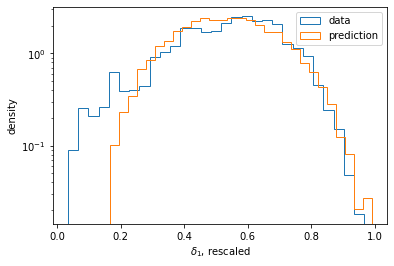

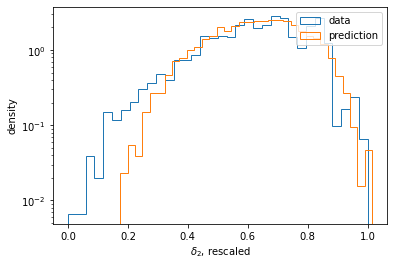

In [59]:
## Density comparison

def compare_density(data, pred, xlabel, log_scale=False):
    '''
    Compares the distribution density of data and pred.
    If log_scale is True, the y-axis is in log scale.
    '''
    fig, ax = plt.subplots()
    bins = len(np.unique(data))
    ax.hist(data,
            histtype='step',
            bins=bins,
            density=True,
            log=log_scale,
            label='data')
    ax.hist(pred,
            histtype='step',
            bins=bins,
            density=True,
            log=log_scale,
            label='prediction')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('density')
    ax.legend(loc='best')
    plt.show()
    

# We plot the density both in log and in linear scale.
for log_scale in (False, True):
    if log_scale:
        print("Density plots in log scale:")
    compare_density(y_test[0],
                    predictions[0],
                    r'$\delta_1$, rescaled',
                    log_scale=log_scale)
    compare_density(y_test[1],
                    predictions[1],
                    r'$\delta_2$, rescaled',
                    log_scale=log_scale)

    # Let's inspect the distribution density of the delta vector components.
    

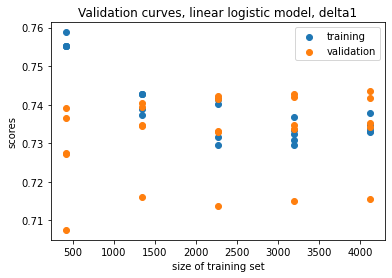

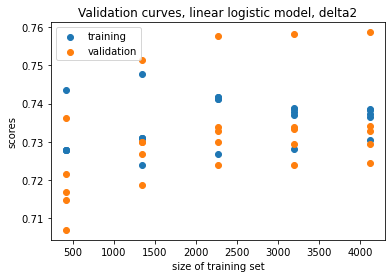

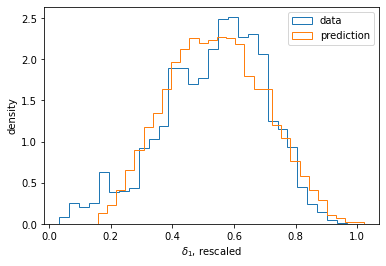

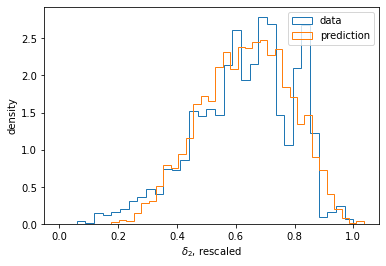

Density plots in log scale:


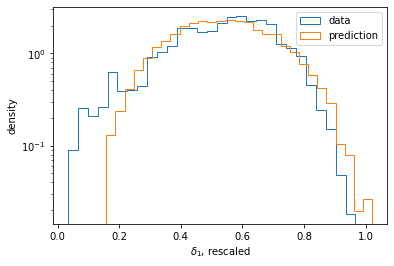

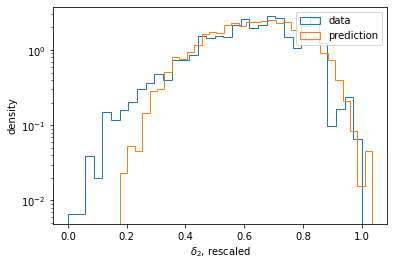

In [60]:
from sklearn.svm import SVR



for delta in (1, 2):
    # Target
    plot_validation_curves(X_test,
                           y_test[delta - 1],
                           SVR(kernel='linear'),
                           'linear logistic model')


svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train[0])
svm_predictions = [svm_model.predict(X_test)]
svm_model.fit(X_train, y_train[1])
svm_predictions.append(svm_model.predict(X_test))


for log_scale in (False, True):
    if log_scale:
        print("Density plots in log scale:")
    compare_density(y_test[0],
                    svm_predictions[0],
                    r'$\delta_1$, rescaled',
                    log_scale=log_scale)
    compare_density(y_test[1],
                    svm_predictions[1],
                    r'$\delta_2$, rescaled',
                    log_scale=log_scale)

linear kernel


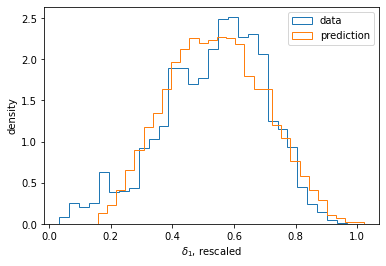

poly kernel


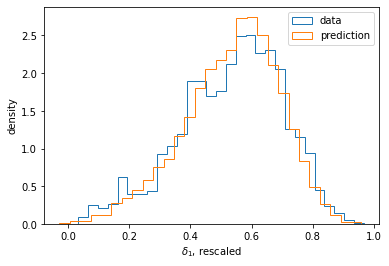

rbf kernel


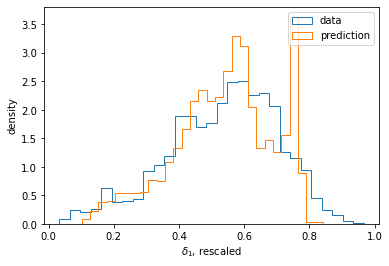

sigmoid kernel


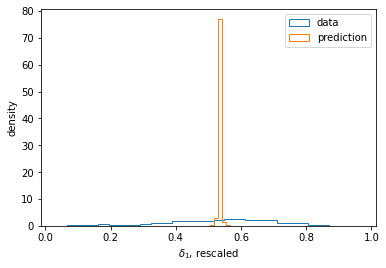

In [61]:
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    print(f'{k} kernel')
    svm_model = SVR(kernel=k)
    svm_model.fit(X_train, y_train[0])
    svm_predictions = svm_model.predict(X_test)
    compare_density(y_test[0],
                    svm_predictions,
                    r'$\delta_1$, rescaled',
                    log_scale=False)

In [62]:
from sklearn.model_selection import GridSearchCV

# Number of subdivisions for the grid search cross-validation.
n_grid_search = 2

params = {'C': np.logspace(-4, 0, num=n_grid_search),
          'gamma': np.logspace(-3, 1, num=n_grid_search)}

# If you have enough memory, you could increase cache_size (measured in Mb) for improved performance.
svm_model = SVR(kernel='rbf', cache_size=4000)
clf = GridSearchCV(svm_model, params)
clf.fit(X, y[0])
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_gamma',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

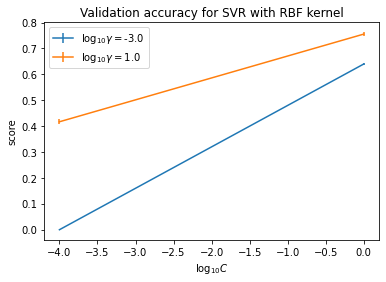

In [63]:
fig, ax = plt.subplots()
Cs = params['C']
for g in params['gamma']:
    mask = clf.cv_results_['param_gamma'] == g
    mean_test_score = clf.cv_results_['mean_test_score'][mask]
    std_test_score = clf.cv_results_['std_test_score'][mask]


    ax.errorbar(np.log10(Cs), mean_test_score, yerr=std_test_score, label=r'$\log_{10}\gamma = $' + f'{np.log10(g):.4}')
    ax.set_xlabel(r'$\log_{10} C$')
    ax.set_ylabel('score')
    ax.set_title('Validation accuracy for SVR with RBF kernel')
    ax.legend(loc='best')

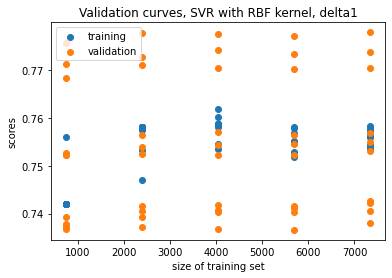

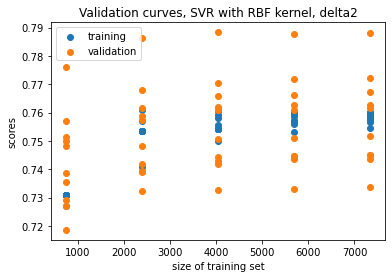

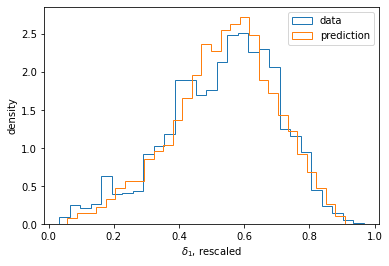

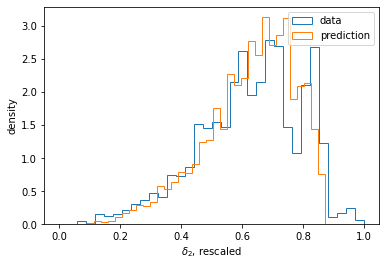

Density plots in log scale:


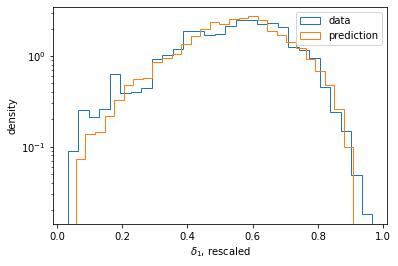

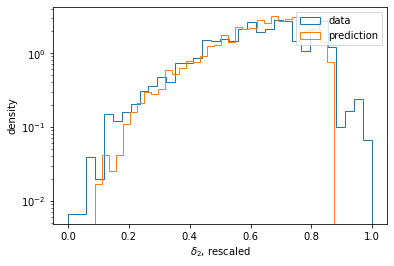

In [64]:
svm_model = SVR(kernel='rbf',
                C=1.,
                gamma=3.6,
                cache_size=4000)


for delta in (1, 2):
    # Target
    plot_validation_curves(X, y[delta - 1], svm_model, 'SVR with RBF kernel', cv=10)


svm_model.fit(X_train, y_train[0])
svm_predictions = [svm_model.predict(X_test)]
svm_model.fit(X_train, y_train[1])
svm_predictions.append(svm_model.predict(X_test))


for log_scale in (False, True):
    if log_scale:
        print("Density plots in log scale:")
    compare_density(y_test[0],
                    svm_predictions[0],
                    r'$\delta_1$, rescaled',
                    log_scale=log_scale)
    compare_density(y_test[1],
                    svm_predictions[1],
                    r'$\delta_2$, rescaled',
                    log_scale=log_scale)

Error estimates on delta1
[0.78877566 0.73245141 0.76925846 0.74712729 0.72736204 0.7399908
 0.75453703 0.746373   0.74725289 0.77732725]
Error estimates on delta2
[0.76568893 0.73131428 0.7756373  0.77436252 0.72734815 0.75120806
 0.74666845 0.75478822 0.7456803  0.77776503]


KeyError: 'slope'

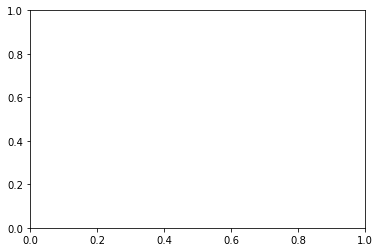

In [65]:
# if True, plots the prediction error, otherwise makes a
# side-by-side plot of the data and the predictions.
plot_error = True


# Error estimates on delta1.
from sklearn.model_selection import cross_val_score
# For SVR, the error estimate is the coefficient of determination R^2 of the regression.
print('Error estimates on delta1')
svm_model.fit(X_train, y_train[0])
print(cross_val_score(svm_model, X_test, y_test[0], cv=10))


# Error estimates on delta2
svm_model.fit(X_train, y_train[1])
print('Error estimates on delta2')
print(cross_val_score(svm_model, X_test, y_test[1], cv=10))

compare_scatter(X_test,
                y_test[0],
                predictions[0],
                r'Error on $\delta_1$',
                plot_error=plot_error)

print("Prediction accuracy on delta2.")

compare_scatter(X_test,
                y_test[1],
                predictions[1],
                r'Error on $\delta_2$',
                plot_error=plot_error)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

params = {'n_estimators': np.linspace(50, 500, num=n_grid_search, dtype=np.int32),
          'learning_rate': np.logspace(-3, 0, num=n_grid_search)}

# If you have enough memory, you could increase cache_size (measured in Mb) for improved performance.
boost_model = AdaBoostRegressor(base_estimator=LinearRegression(),
                                random_state=random_state)

clf = GridSearchCV(boost_model, params)
clf.fit(X, y[0])


# Plot of the cross-validation curves.
fig, ax = plt.subplots()
NEs = params['n_estimators']
for r in params['learning_rate']:
    mask = clf.cv_results_['param_learning_rate'] == r
    mean_test_score = clf.cv_results_['mean_test_score'][mask]
    std_test_score = clf.cv_results_['std_test_score'][mask]


    ax.errorbar(NEs,
                mean_test_score,
                yerr=std_test_score,
                label=r'$\log_{10}r = $' + f'{np.log10(r):.4}')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('score')
    ax.set_title('Validation accuracy for AdaBoost regression with Linear model as a base model')
    ax.legend(loc='best')